# Horizon to JSON

In [1]:
import numpy as np

In [2]:
ls data

E-38.las           F3_horizon.txt     F3_seismic.txt.gz  seismic.h5


In [3]:
raw = np.loadtxt('data/F3_horizon.txt')

In [4]:
raw.shape

(36481, 3)

In [5]:
nulls = np.amax(raw)
np.place(raw, raw==nulls, np.nan)

In [6]:
ilinit, ilfin = np.amin(raw[:,0]), np.amax(raw[:,0])
xlinit, xlfin = np.amin(raw[:,1]), np.amax(raw[:,1])
nIL, nXL = ilfin-ilinit+1, xlfin-xlinit+1

print("inline range {} to {} ({} inlines)".format( ilinit, ilfin, ilfin - ilinit + 1))
print("xline range {} to {} ({} xlines)".format(xlinit, xlfin, xlfin - xlinit + 1))

inline range 310.0 to 500.0 (191.0 inlines)
xline range 310.0 to 500.0 (191.0 xlines)


In [7]:
z = np.empty((nIL, nXL))
#amp = np.empty_like(z)
#sim = np.empty_like(z)

for i, row in enumerate(raw):
    il = row[0] - ilinit
    xl = row[1] - xlinit
    zi = row[2]
#    ai = row[3]
#    si = sim_raw[i][3]
    
    z[il, xl] = zi
#    amp[il, xl] = ai
#    sim[il, xl] = si

/Users/matt/anaconda/envs/test/lib/python3.4/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/matt/anaconda/envs/test/lib/python3.4/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [8]:
z.shape

(191, 191)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

ImportError: No module named 'matplotlib'

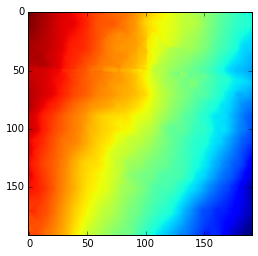

In [27]:
plt.imshow(z)

In [28]:
z

array([[ 1041.08464718,  1040.96233845,  1040.83991051, ...,
          988.84689808,   988.57647181,   988.28023672],
       [ 1041.07832909,  1040.94958305,  1040.7756567 , ...,
          988.85476589,   988.56496811,   988.24298382],
       [           nan,  1040.91143608,  1040.72463512, ...,
          988.87133598,   988.56216669,   988.22718859],
       ..., 
       [ 1025.58124065,  1026.02481842,  1026.3184309 , ...,
          957.2879076 ,   957.000494  ,   956.65061474],
       [ 1025.4406929 ,  1026.42214298,  1026.74090862, ...,
          957.1596384 ,   956.94088936,   956.63458109],
       [ 1025.40230751,  1027.65572071,  1027.52387524, ...,
          957.06582069,   956.98422194,   956.74568415]])

In [29]:
np.amax(z)

(191, 191)

In [41]:
data = {'metadata': {},
        'z': {},
        'geometry': {}
       }

In [42]:
import uuid

In [43]:
line = z[50,:]

data['name'] = 'FS4'
data['location'] = 'Netherlands'
data['survey'] = 'F3'
data['type'] = 'interpretation'
data['interpreter'] = 'unknown'
data['formation'] = 'unknown'
data['age'] = 'unknown'
data['company'] = 'unknown'
data['uuid'] = str(uuid.uuid1())

data['metadata']['dim'] = line.ndim
data['metadata']['shape'] = line.shape
data['metadata']['min'] = np.amin(line)
data['metadata']['max'] = np.amax(line)
data['metadata']['global_min'] = np.amin(z)
data['metadata']['global_max'] = np.amax(z)

data['z']['units'] = 'ms'
data['z']['domain'] = 'time'

data['geometry']['inline_min'] = 50  # Can read these from original datafile,
data['geometry']['inline_max'] = 50  # but now just have to know them.
data['geometry']['xline_min'] = 310
data['geometry']['xline_max'] = 500

In [44]:
data['data'] = line.tolist()

In [45]:
import os, json

env = %env

path = os.path.join(env['HOME'], os.sep.join(['Dropbox', 'Public']))
with open(os.path.join(path, 'horizon.json'), 'w') as f:
    f.write(json.dumps(data))